In [162]:
import pathlib
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import scipy
from skimage.filters import threshold_otsu

def convert_images(directory):
    input_path = pathlib.Path(directory)
    images = {}

    for file_path in input_path.glob('*.tif'):
        try:
            # Load the TIFF file into a numpy array
            image = tifffile.imread(file_path)

            # standardize image dimensions
            with tifffile.TiffFile(file_path) as tif_file:
                metadata = tif_file.imagej_metadata
            num_channels = metadata.get('channels', 1)
            image = image.reshape(num_channels, 
                                    image.shape[-2],  # rows
                                    image.shape[-1])  # cols
            
            filtered_image = scipy.ndimage.gaussian_filter(image, sigma = 2.0)
            
            images[file_path.name] = filtered_image
                        
        except tifffile.TiffFileError:
            print(f"Warning: Skipping '{file_path.name}', not a valid TIF file.")

    # Sort the dictionary keys alphabetically
    images = {key: images[key] for key in sorted(images)}

    return images       

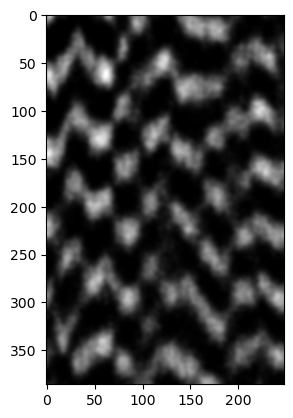

variance size: 50


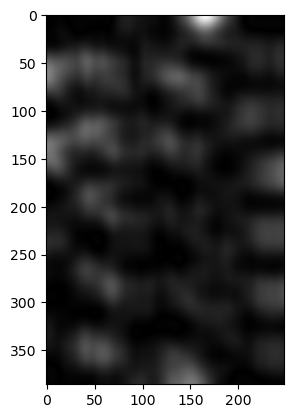

variance size: 50


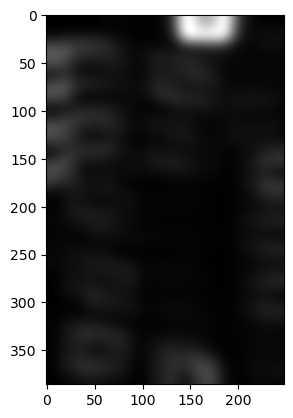

In [190]:
def reg_variance_transform(image_array, win_low, win_high, range_check, window):

    size = window

    if range_check:
        window_range = range(win_low,win_high,1)
        max_variance = -1
        size = -1

        for window in window_range:
            result = abs(scipy.ndimage.uniform_filter(image_array**2, size=window, output=np.float64) - 
                        (scipy.ndimage.uniform_filter(image_array, size=window, output=np.float64)**2))
            variance = result.max()
            if variance > max_variance:
                max_variance = variance
                size = window
    
    output_image_array = abs(scipy.ndimage.uniform_filter(image_array**2, size=size, output=np.float64) 
                        - (scipy.ndimage.uniform_filter(image_array, size=size, output=np.float64)**2))

    return output_image_array, size

images = convert_images('/Users/domchom/Desktop/cell_profiler_test/Kymograph_variance')

for image in images:
    img = images[image]
    plt.imshow(img[0], cmap='gray')
    plt.show()

    variance_image, size = reg_variance_transform(img, 5, 50, False, 50)
    print(f'variance size: {size}')
    plt.imshow(variance_image[0], cmap='gray')
    plt.show()

    variance_again_image, size = reg_variance_transform(variance_image, 5, 50, False, 50)
    print(f'variance size: {size}')
    plt.imshow(variance_again_image[0], cmap='gray')
    plt.show()
    

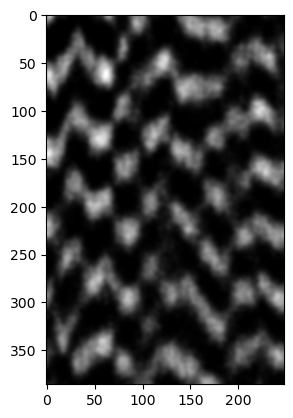

variance size: 5


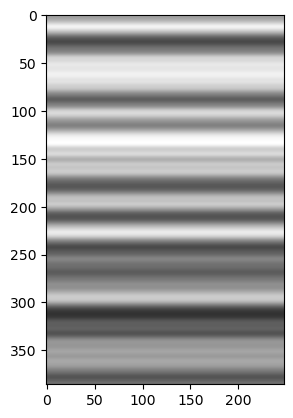

variance size: 5


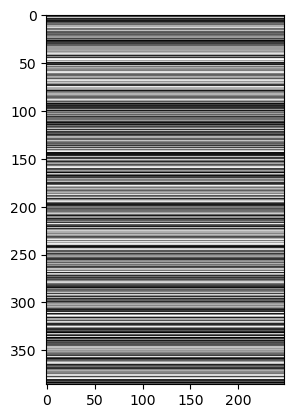

In [195]:
def linear_variance_transform(image_array, win_low, win_high, range_check, window):
    '''this version does not go column by column. It finds the variance of all columns together'''

    num_cols = image_array.shape[-1]
    num_rows = image_array.shape[-2]

    size = window

    if range_check:
        window_range = range(win_low,win_high,1)
        max_variance = -1
        size = -1
        for window in window_range:
            window_xtra = int((window - 1) / 2)
            results_list = []
            for row_num in range(0, num_rows):
                row_values = image_array[:, row_num - window_xtra:row_num + window_xtra, :]
                mean = np.mean(row_values)
                result = np.mean((row_values - mean) ** 2)

                # print(f'row_num {row_num}')
                # print(f'mean {mean}')
                # print(f'result {result}')

                results_list.append(result)

            variance = max(results_list)
            if variance > max_variance:
                max_variance = variance
                size = window

    variance_image = np.zeros_like(image_array)
    size_xtra = int((size - 1) / 2)

    for row_num in range(0, num_rows):
        row_values = image_array[:, row_num - size_xtra:row_num + size_xtra, :]
        mean = np.mean(row_values)
        result = np.mean((row_values - mean) ** 2)
        variance_image[:, row_num, :] = result
    
    return variance_image, size

for image in images:
    plt.imshow(images[image][0], cmap='gray')
    plt.show()

    variance_image, size = linear_variance_transform(images[image], 1, 5, False, 5)
    print(f'variance size: {size}')
    plt.imshow(variance_image[0], cmap='gray')
    plt.show()

    variance_again_image, size = linear_variance_transform(variance_image, 1, 5, False, 5)
    print(f'variance size: {size}')
    plt.imshow(variance_again_image[0], cmap='gray')
    plt.show()

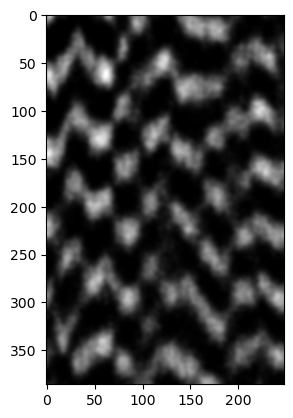

ValueError: zero-size array to reduction operation maximum which has no identity

In [201]:
def linear_variance_transform_col(image_array, win_low, win_high, range_check, window):

    num_cols = image_array.shape[-1]
    num_rows = image_array.shape[-2]

    size = window

    if range_check:
        window_range = range(win_low,win_high,1)
        max_variance = -1
        size = -1
        for window in window_range:
            window_xtra = int((window - 1) / 2)
            results_list = []
            for col_num in range(num_cols):
                row_results = []
                for row_num in range(window_xtra, num_rows):
                    row_values = image_array[:, row_num - window_xtra:row_num + window_xtra, col_num]
                    mean = np.mean(row_values)
                    result = np.max((row_values - mean) ** 2)

                    row_results.append(result)

                    # print(f'row_num {row_num}')
                    # print(f'mean {mean}')
                    # print(f'result {result}')

                results_list.append(row_results)

            variance = max(max(inner_list) for inner_list in results_list)
            if variance > max_variance:
                max_variance = variance
                size = window

    variance_image = np.zeros_like(image_array)
    size_xtra = int((size - 1) / 2)
    for col_num in range(num_cols):
        for row_num in range(0, num_rows):
            row_values = image_array[:, row_num-size_xtra:row_num+size_xtra, col_num]
            mean = np.mean(row_values, axis=1, keepdims=True)
            result = np.mean((row_values - mean) ** 2, axis=1, keepdims=True)
            variance_image[:, row_num, col_num] = result
    return variance_image, size

def rescale_image(image_array):
    min_val = np.min(image_array)
    max_val = np.max(image_array)
    scaled_array = (image_array - min_val) / (max_val - min_val)
    return scaled_array

for image in images:
    img = images[image]
    plt.imshow(img[0], cmap='gray')
    plt.show()

    variance_image, size = linear_variance_transform_col(images[image], 1, 25, True, 5)
    print(f'variance size: {size}')
    plt.imshow(variance_image[0], cmap='gray')
    plt.show()

    variance_again_image, size = linear_variance_transform_col(variance_image, 1, 25, True, 5)
    print(f'variance size: {size}')
    plt.imshow(variance_again_image[0], cmap='gray')
    plt.show()